## Connor-Stevens Simulation Notebook

This Jupyter (python) notebook contains a simple simulation of a single compartment neuron using voltage gated sodium and potassium channels and the equations developed by Hodgkin and Huxley with the addition of one more channel, the A channel, as modeled by Connor and Stevens. The parameters are taken from _Theoretical and Computational Neuronscience_ by Dayan and Abbott. You can clone and modify the code to perform the analyses for [Assignment 3 for Rice ELEC-548](https://elec548.github.io/Assignments/hw4.html). Special thanks to Caleb Lu for code.

In [1]:
# Begin by importing useful files
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib parameter commands must be run before any matplotlib commands are, 
#   and it is advisable to reload the notebook if you want to change them.
#   User "notebook" for pan and zoom, or "inline" for best rendering.
#%matplotlib notebook 
%matplotlib inline

#import seaborn as sns # seaborn styles things nicely
#sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 
#            'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 
#            'xtick.labelsize': 12 })
#sns.set_style('white')

In [8]:
def cst(I, dt):
    ##########################################################################
    # Simulate the membrane potential of a CSTneuron with
    #   a given input current
    # Input:
    #    I = current in uA/mm^2a
    #    dt = time step between I measurments [ms]
    #
    # Output:
    #    Vm = membrane voltage in mV
    #    n = sodium activation
    #    m = potassium activation
    #    h = 1 - potassium inactivation

    # This function simulates a dynamical system with state variables
    #    DV = 1/C (I - Ik - Ina - Il)
    #    Il = gl(V-El)
    #    Ik = gk*n^4(V-Ek)
    #    Ina = gna*m^3*h(V-Ena)
    #    Dn = (ninf(V) - n)/taun(V) (same for m, h )

    # Summary of units: I = uA / mm^2; V = mV; g = mS; g*V = uA; C = uF; uA/uC*ms = mV

    ##########################################################################
    # Constants:
    # Reversal potentials for various ions [mV]
    Ek = -72
    Ena = 55
    El = -17
    Ea = -75

    # Membrane capacitance:
    C = 0.01 #[uF/mm^2]

    # Maximum conductances [mS/mm^2]
    gna = 1.2
    gk = 0.2
    gl = 0.003
    ga = 0.477
##########################################################################
    # Gating variables:
    # activation Na [m]
    alpha_m = lambda V: 0.38*(V + 29.7) / (1 - np.exp(-0.1*(V + 29.7)))
    beta_m = lambda V: 15.2 * np.exp(-0.0556*(V + 54.7))
    # inactivation Na [h]
    alpha_h = lambda V: 0.266*np.exp(-0.05*(V + 48))
    beta_h = lambda V:  3.8/(1 + np.exp(-0.1*(V + 18)))
    
    tau_m = lambda V: 1/(alpha_m(V) + beta_m(V))
    m_inf = lambda V: alpha_m(V) * tau_m(V)
    tau_h = lambda V: 1/(alpha_h(V) + beta_h(V))
    h_inf = lambda V: alpha_h(V) * tau_h(V);

    # activation K [n]
    alpha_n = lambda V: 0.02*(V + 45.7) / (1 - np.exp(-0.1*(V + 45.7)))
    beta_n = lambda V: 0.25 * np.exp(-0.0125*(V + 55.7))
    
    tau_n = lambda V: 1 /(alpha_n(V) + beta_n(V))
    n_inf = lambda V: alpha_n(V) * tau_n(V)
    
    # A-current transient potassium conductance
    #a
    a_inf = lambda V: ((0.0761*np.exp(0.0314*(V+94.22)))/(1+np.exp(0.0346*(V+1.17))))**(1.0/3)
    tau_a = lambda V: 0.3632 + 1.158/(1+np.exp(.0497*(V+55.96)))
    #b
    b_inf = lambda V: (1/(1+np.exp(0.0688*(V+53.3))))**4
    tau_b = lambda V: 1.24 + 2.678/(1+np.exp(0.0624*(V+50)))

    # Initializations
    n = np.zeros(len(I)); m = np.zeros(len(I)); h = np.zeros(len(I)); V = np.zeros(len(I))
    a = np.zeros(len(I)); b = np.zeros(len(I))

    # Set initial conditions:
    Vstart = -68 #[mV] (start membrane potential at steady state value)
    V[0] = Vstart #[mV]
    n[0] = n_inf(Vstart); m[0] = m_inf(Vstart); h[0] = h_inf(Vstart); a[0] = a_inf(Vstart); b[0] = b_inf(Vstart)

    ##########################################################################
    # Simulation: iteratatively update the variables using the forward Euler method
    for ii in range(len(I)-1):
        # Update activation state variables
        n[ii+1] = n[ii] + dt*(n_inf(V[ii]) - n[ii])/tau_n(V[ii])
        m[ii+1] = m[ii] + dt*(m_inf(V[ii]) - m[ii])/tau_m(V[ii])
        h[ii+1] = h[ii] + dt*(h_inf(V[ii]) - h[ii])/tau_h(V[ii])
        a[ii+1] = a[ii] + dt*(a_inf(V[ii]) - a[ii])/tau_a(V[ii])
        b[ii+1] = b[ii] + dt*(b_inf(V[ii]) - b[ii])/tau_b(V[ii])
        V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4 *(V[ii]-Ek) 
                                - gna*m[ii]**3*h[ii]*(V[ii]-Ena) 
                                - ga*a[ii]**3*b[ii]*(V[ii]-Ea));

    return V, m, n, h



The code above implements the Hodgkin Huxley model using the Forward Euler method to solve the differential equations. For your assignment, you will test the effects of various parameters on the solution, and modify it by adding an addition voltage-gated ion channel. In the following cells, we inject a current pulse to demonstrate that this depolarization causes and action potential in the model.

In [9]:
dt = 1e-2; # 10 us
I = np.zeros(int(400 / dt)) # 1 s of zero current
I[int(100/dt):int(300/dt)] = 0.1; # 0.2 uA / mm^2 current for 10 ms
V, m, n, h = cst(I, dt) # simulate it!


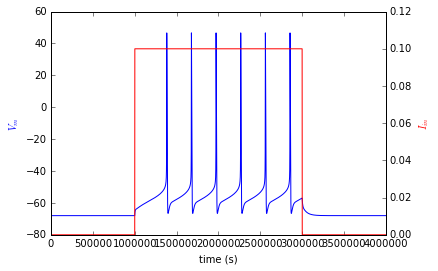

In [10]:
# Generate a two y-axis plot with current (red) and resulting membrane potential (blue)
fig, ax1 = plt.subplots()
t = np.cumsum(np.ones(int(400/dt)))/dt
ax1.plot(t, V, 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$V_{m}$', color='b')
#ax1.set_ylim([-100, 80])
ax2 = ax1.twinx()
ax2.plot(t, I, 'r-')
#ax2.set_ylim([-0.5, 5])
ax2.set_ylabel(r'$I_{in}$', color='r')
#ax1.set_xlim([0.1, 0.3])


In [11]:
fluctuation = np.random.randn(len(I)) * 0.1
smoothed_fluctuation = np.convolve(np.ones(100) / 100, fluctuation)
smoothed_fluctuation = smoothed_fluctuation[0:len(I)]
print(np.std(fluctuation))
print(np.std(smoothed_fluctuation))
print(np.mean(smoothed_fluctuation))

0.100729285528
0.0107774250476
-0.000605002146062


1.8465650081634521


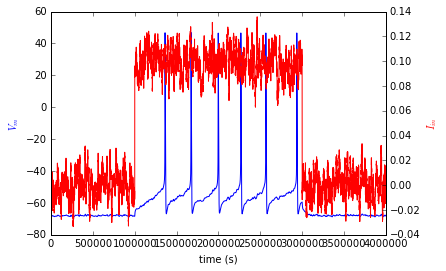

In [12]:
import time
t0 = time.time()
V, m, n, h = cst(I + smoothed_fluctuation, dt) # simulate it!
print(time.time() - t0)
# Generate a two y-axis plot with current (red) and resulting membrane potential (blue)
fig, ax1 = plt.subplots()
t = np.cumsum(np.ones(int(400/dt)))/dt
ax1.plot(t, V, 'b-')
ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$V_{m}$', color='b')
#ax1.set_ylim([-100, 80])
ax2 = ax1.twinx()
ax2.plot(t, I + smoothed_fluctuation, 'r-')
#ax2.set_ylim([-0.5, 5])
ax2.set_ylabel(r'$I_{in}$', color='r')
#ax1.set_xlim([0.1, 0.3])


